Libralies

In [104]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from yahoo_fin.stock_info import get_data
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
pd.options.mode.chained_assignment = None 

Constants

In [105]:
PATH_OF_TRAIN_DATA = os.path.dirname(os.path.abspath('eda.ipynb')) + '\\oil_gas_train\\'
PATH_OF_TEST_DATA = os.path.dirname(os.path.abspath('eda.ipynb')) + '\\oil_gas_train_test\\'
stock_data = {}

Functions

In [106]:
def download_data(path: str) -> pd.DataFrame:
    names_of_train_tables = os.listdir(path)
    # i do not want to append data to dataframe by parts, so i use dictionary at the beginning
    Container_for_dataframe = {"company_name": [], "rev": [], "date": [], "op_in": []}
    for name in names_of_train_tables:
        name_of_table = PATH_OF_TRAIN_DATA + name
        data = pd.read_excel(name_of_table)
        rev = data.iloc[28].tolist()[9:51]
        date = data.iloc[27].tolist()[9:51]
        op_in = data.iloc[42].tolist()[9:51]
        company_name = name[:-5]
        for i in range(len(rev)):
            Container_for_dataframe["company_name"].append(company_name)
            Container_for_dataframe["rev"].append(rev[i])
            Container_for_dataframe["date"].append(date[i])
            Container_for_dataframe["op_in"].append(op_in[i])
    DF = pd.DataFrame(Container_for_dataframe)
    #don't want to get null data
    DF = DF.loc[DF['rev'] != 0]
    return DF

In [154]:
def company_cross_validation(data: pd.DataFrame, name_of_column: str, model, metrics, train_lenght: int=0, step: int=1, plot: bool=False) -> float:
    """Cross validation for one company data"""
    values_for_metric = {"test":[], "model":[]}
    len_of_data = len(data[name_of_column])
    data['Time'] = np.arange(len(data.date))
    data = data.reset_index(drop=True)
    if not train_lenght:
        train_lenght = int((len_of_data * 0.6)//1)
    for n in range(train_lenght + 1, len_of_data, step):
        train_data = data.iloc[: n]
        values_for_metric["model"].append(model(train_data, name_of_column))
        values_for_metric["test"].append(data[name_of_column][n])
    if plot:
        plt.figure(figsize=(20,10))
        plt.plot(values_for_metric["model"], label='Predicted')
        plt.plot(values_for_metric["test"], label='Actual')
        plt.title("Predicted and actual values for " + model.__name__ + ". Name of company is " + data.company_name[0] + ".")
        plt.legend()
        plt.grid()
        plt.show()
    return metrics(values_for_metric["test"], values_for_metric["model"])

In [148]:
def companies_validation(data: pd.DataFrame, name_of_column: str, 
                        model, metrics, train_lenght: int=0, 
                        step: int=1, plot: bool=False) -> pd.DataFrame:
    """Cross validation for a few companies data"""
    validation = {}
    for company_name in data.company_name.unique():
        DF_of_one_company = data.loc[data.company_name == company_name] 
        validation[company_name] = company_cross_validation(DF_of_one_company, name_of_column, model, metrics, plot = plot)
    return pd.DataFrame.from_dict(validation, orient='index', columns=[name_of_column])

In [109]:
def get_stock_price_for_date(date: datetime, ticker: str, 
                                 start_date: datetime = datetime(2011, 3, 1),
                                 end_date: datetime = datetime(2020, 7, 30)) -> float:
    if date < start_date:
        return 50513.14505
    if ticker not in stock_data:
        stock_data[ticker] = get_data(ticker, start_date = start_date, end_date = end_date, index_as_date = True, interval="1d").open 
        stock_data[ticker] = stock_data[ticker].dropna()       
    price_for_date = stock_data[ticker].loc[stock_data[ticker].index < date][-1]
    return price_for_date

In [110]:
def linear_model(data: pd.DataFrame, name_of_column: str):
    """Least squares Linear Regression."""
    model = LinearRegression().fit(np.array(data.Time[:]).reshape((-1,1)), data[name_of_column][:])
    next_value = model.coef_[0] * (data.Time[:].max() + 1) + model.intercept_ 
    return next_value

In [111]:
def multilinear_model(data: pd.DataFrame, name_of_column: str):
    """Least squares Linear Regression with multiply variables."""
    data["future_value"] = data[name_of_column].shift(-1)
    row_to_predict = data.tail(1)
    data = data.dropna()
    model = LinearRegression().fit(data[["rev","op_in","usd","Time"]], data["future_value"][:])
    next_value = model.predict(row_to_predict[["rev","op_in","usd","Time"]])[0]
    return next_value

In [112]:
def naive_model(data: pd.DataFrame, name_of_column: str) -> float:
    return data[name_of_column].iloc[-1]

In [143]:
def random_forest_model(data: pd.DataFrame, name_of_column: str):
    """."""
    data["future_value"] = data[name_of_column].shift(-1)
    row_to_predict = data[data.columns.difference(['future_value', 'company_name', 'date'])].tail(1)
    row_to_predict_scaled = StandardScaler().fit_transform(row_to_predict)
    data = data.dropna()
    data_X = data[data.columns.difference(['future_value', 'company_name', 'date'])]
    data_X_scaled = StandardScaler().fit_transform(data_X)
    data_Y = np.array(data["future_value"])
    forest_model = RandomForestRegressor()
    forest_model.fit(data_X_scaled, data_Y)   
    next_value = forest_model.predict(row_to_predict_scaled)
    return next_value

Download data

In [114]:
Train_DF = download_data(PATH_OF_TRAIN_DATA)

Distributed the data across three clusters using k-means. There are three clusters, and in one of them there is only one point with drastically different values from others. So i just drop it.

In [115]:
revenues = pd.DataFrame(Train_DF.groupby('company_name')['rev'].mean())
op_ins = pd.DataFrame(Train_DF.groupby('company_name')['op_in'].mean())
clasterization = pd.concat([revenues,op_ins], axis=1, join='inner').reset_index()
kmeans = KMeans(n_clusters=3) 
kmeans.fit(np.array(clasterization['rev']).reshape((-1,1)), clasterization['op_in'])
clasterization['claster'] = kmeans.labels_
clasterization = clasterization.drop(clasterization[(clasterization.claster == 1)].index)

I divide the data into two clusters in order to do different processing for them in the future.

In [116]:
Train_DF_Small = clasterization.loc[clasterization.claster == 0]
Train_DF_Small.drop('claster', axis = 1)
Train_DF_Mid = clasterization.loc[clasterization.claster == 2]
Train_DF_Mid.drop(columns = ['claster', 'rev', 'op_in'])
Train_DF_midlle = Train_DF[Train_DF['company_name'].isin(Train_DF_Mid.company_name)] 
Train_DF_small = Train_DF[Train_DF['company_name'].isin(Train_DF_Small.company_name)] 

Find mse for naive model

In [117]:
Validation_small_rev = companies_validation(Train_DF_small,'rev', naive_model, mean_absolute_error)
Validation_small_op_in = companies_validation(Train_DF_small,'op_in', naive_model, mean_absolute_error)
Validation_midlle_rev = companies_validation(Train_DF_midlle,'rev', naive_model, mean_absolute_error)
Validation_midlle_op_in = companies_validation(Train_DF_midlle,'op_in', naive_model, mean_absolute_error)

In [118]:
print(Validation_small_rev.mean()
    ,Validation_small_op_in.mean()
    ,Validation_midlle_rev.mean()
    ,Validation_midlle_op_in.mean(), sep='\n')

rev    51.69805
dtype: float64
op_in    48.933637
dtype: float64
rev    306.893456
dtype: float64
op_in    249.094686
dtype: float64


Test data. I do everything similarly to the training sample.

In [119]:
Test_DF = download_data(PATH_OF_TEST_DATA)

In [120]:
Test_DF["usd"] = Test_DF["date"].map(lambda y: get_stock_price_for_date(y,"USDRUB=X"))
Test_DF["oil"] = Test_DF["date"].map(lambda y: get_stock_price_for_date(y,"BZ=F"))

In [121]:
revenues = pd.DataFrame(Test_DF.groupby('company_name')['rev'].mean())
op_ins = pd.DataFrame(Test_DF.groupby('company_name')['op_in'].mean())
clasterization = pd.concat([revenues,op_ins], axis=1, join='inner').reset_index()
kmeans = KMeans(n_clusters=3) 
kmeans.fit(np.array(clasterization['rev']).reshape((-1,1)), clasterization['op_in'])

KMeans(n_clusters=3)

In [122]:
clasterization['claster'] = kmeans.labels_
clasterization = clasterization.drop(clasterization[(clasterization.claster == 1)].index)
Test_DF_Small = clasterization.loc[clasterization.claster == 0]
Test_DF_Small.drop('claster', axis = 1)
Test_DF_Mid = clasterization.loc[clasterization.claster == 2]
Test_DF_Mid.drop(columns = ['claster', 'rev', 'op_in'])
Test_DF_midlle = Test_DF[Test_DF['company_name'].isin(Test_DF_Mid.company_name)] 
Test_DF_small = Test_DF[Test_DF['company_name'].isin(Test_DF_Small.company_name)]
Validation_small_rev = companies_validation(Test_DF_small,'rev', naive_model, mean_absolute_error)
Validation_small_op_in = companies_validation(Test_DF_small,'op_in', naive_model, mean_absolute_error)
Validation_midlle_rev = companies_validation(Test_DF_midlle,'rev', naive_model, mean_absolute_error)
Validation_midlle_op_in = companies_validation(Test_DF_midlle,'op_in', naive_model, mean_absolute_error) 

In [123]:
print(Validation_small_rev.mean()
    ,Validation_small_op_in.mean()
    ,Validation_midlle_rev.mean()
    ,Validation_midlle_op_in.mean(), sep='\n')

rev    52.722084
dtype: float64
op_in    50.144816
dtype: float64
rev    306.893456
dtype: float64
op_in    249.094686
dtype: float64


In [124]:
Validation_small_rev = companies_validation(Test_DF_small,'rev', linear_model, mean_absolute_error)
Validation_small_op_in = companies_validation(Test_DF_small,'op_in', linear_model, mean_absolute_error)
Validation_midlle_rev = companies_validation(Test_DF_midlle,'rev', linear_model, mean_absolute_error)
Validation_midlle_op_in = companies_validation(Test_DF_midlle,'op_in', linear_model, mean_absolute_error) 

In [125]:
print(Validation_small_rev.mean()
    ,Validation_small_op_in.mean()
    ,Validation_midlle_rev.mean()
    ,Validation_midlle_op_in.mean(), sep='\n')

rev    86.596444
dtype: float64
op_in    62.278786
dtype: float64
rev    983.335832
dtype: float64
op_in    424.698657
dtype: float64


Linear Regression with multiply variables with data about USDRUB

In [126]:
Validation_small_rev = companies_validation(Test_DF_small,'rev', multilinear_model, mean_absolute_error)
Validation_small_op_in = companies_validation(Test_DF_small,'op_in', multilinear_model, mean_absolute_error)
Validation_midlle_rev = companies_validation(Test_DF_midlle,'rev', multilinear_model, mean_absolute_error)
Validation_midlle_op_in = companies_validation(Test_DF_midlle,'op_in', multilinear_model, mean_absolute_error)

Results are better than for simple linear regression but still they are worse than naive model

In [127]:
print(Validation_small_rev.mean()
    ,Validation_small_op_in.mean()
    ,Validation_midlle_rev.mean()
    ,Validation_midlle_op_in.mean(), sep='\n')

rev    59.895678
dtype: float64
op_in    72.675673
dtype: float64
rev    450.193068
dtype: float64
op_in    234.528025
dtype: float64


Random forest

In [ ]:
Validation_small_rev = companies_validation(Test_DF_small,'rev', random_forest_model, mean_absolute_error)
Validation_small_op_in = companies_validation(Test_DF_small,'op_in', random_forest_model, mean_absolute_error)
Validation_midlle_rev = companies_validation(Test_DF_midlle,'rev', random_forest_model, mean_absolute_error)
Validation_midlle_op_in = companies_validation(Test_DF_midlle,'op_in', random_forest_model, mean_absolute_error)

In [136]:
print(Validation_small_rev.mean()
    ,Validation_small_op_in.mean()
    ,Validation_midlle_rev.mean()
    ,Validation_midlle_op_in.mean(), sep='\n')

rev    132.438794
dtype: float64
op_in    62.293017
dtype: float64
rev    886.315709
dtype: float64
op_in    350.935163
dtype: float64


Some graphs for different models

In [155]:
Some_companies_small = Test_DF_small.company_name.unique()[:2]
Some_companies_midlle = Test_DF_midlle.company_name.unique()[:2]

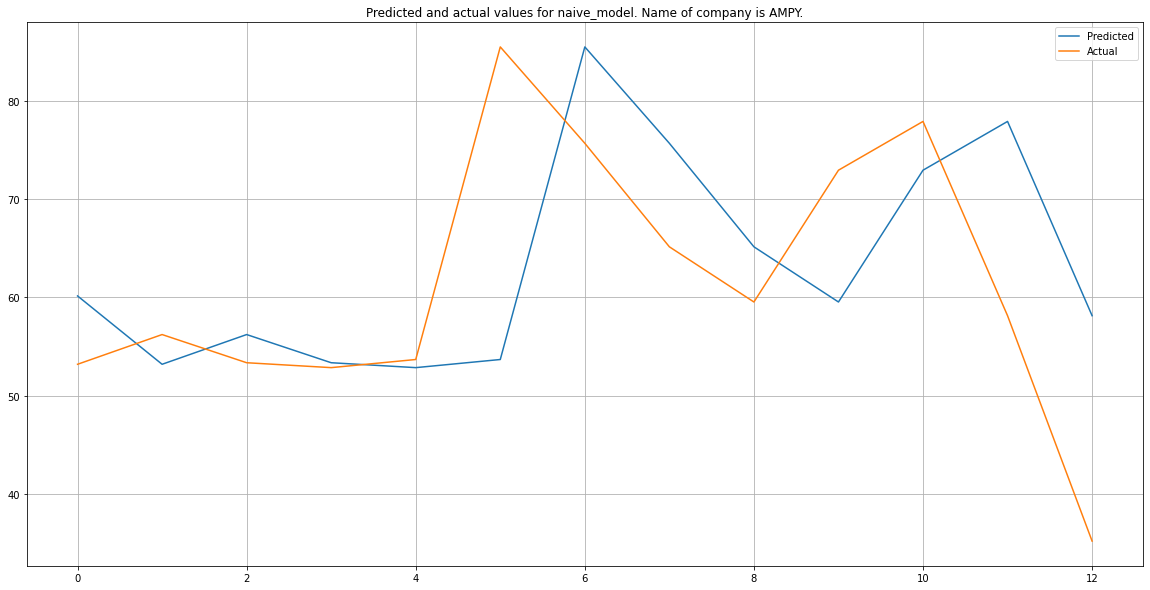

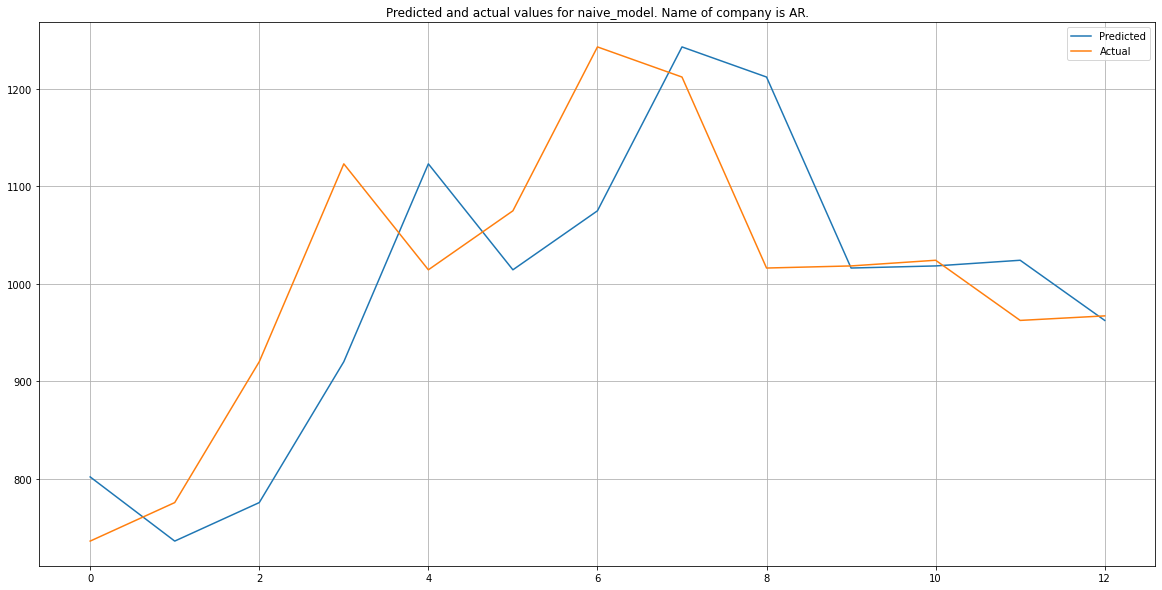

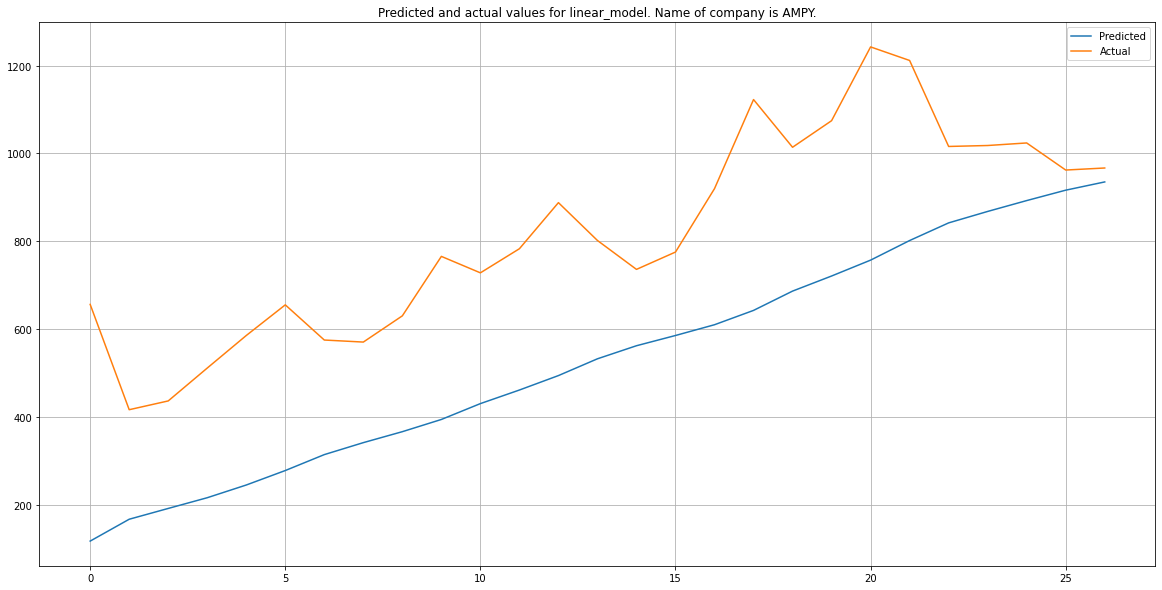

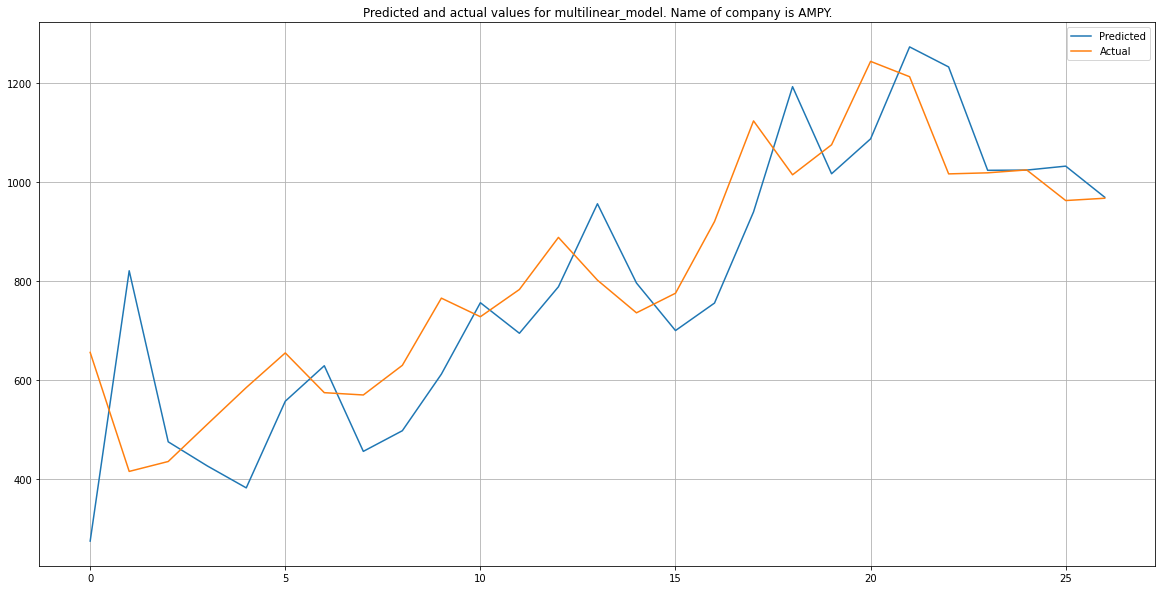

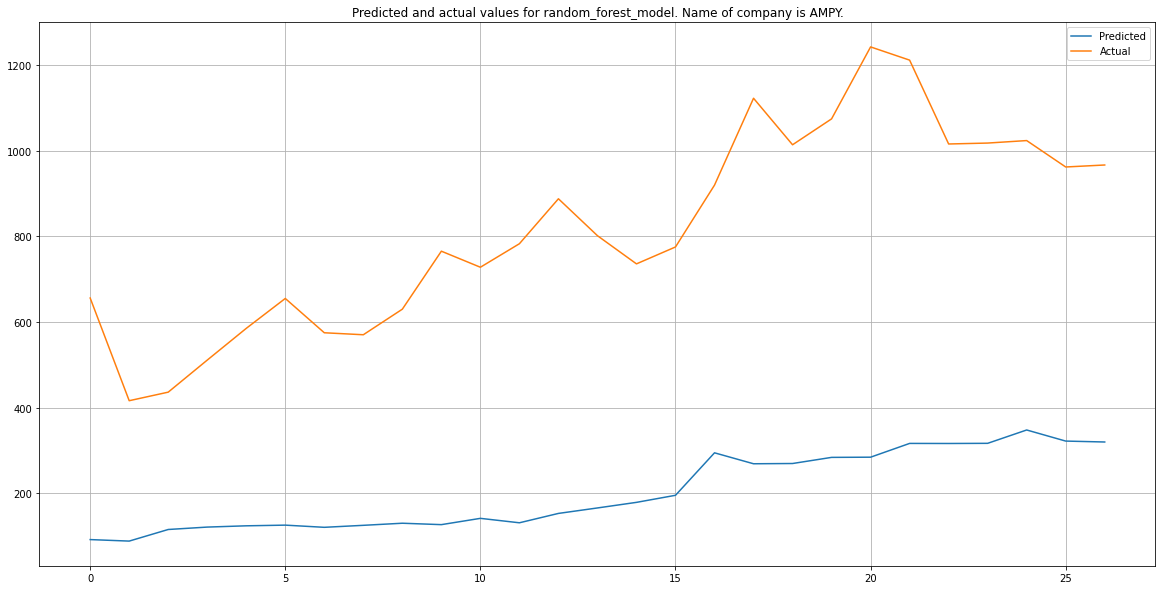

615.4319637185187

In [157]:
companies_validation(Test_DF_small[Test_DF_small['company_name'].isin(Some_companies_small)] ,'rev', naive_model, mean_absolute_error, plot = True)
companies_validation(Test_DF_small[Test_DF_small['company_name'].isin(Some_companies_small)] ,'rev', linear_model, mean_absolute_error, plot = True)
companies_validation(Test_DF_small[Test_DF_small['company_name'].isin(Some_companies_small)] ,'rev', multilinear_model, mean_absolute_error, plot = True)
companies_validation(Test_DF_small[Test_DF_small['company_name'].isin(Some_companies_small)] ,'rev', random_forest_model, mean_absolute_error, plot = True)

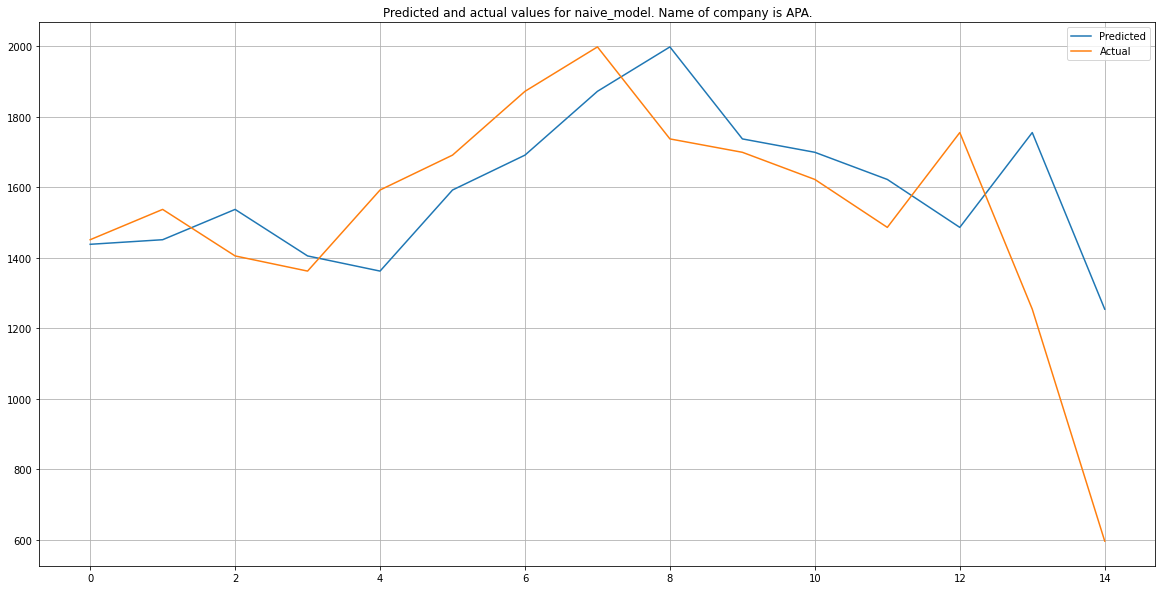

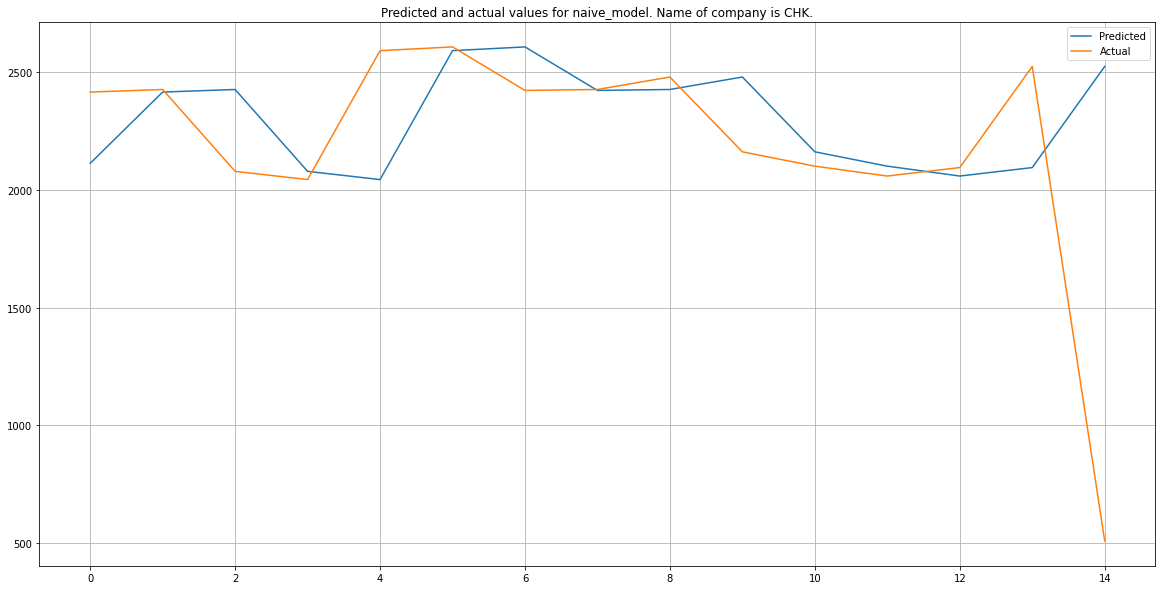

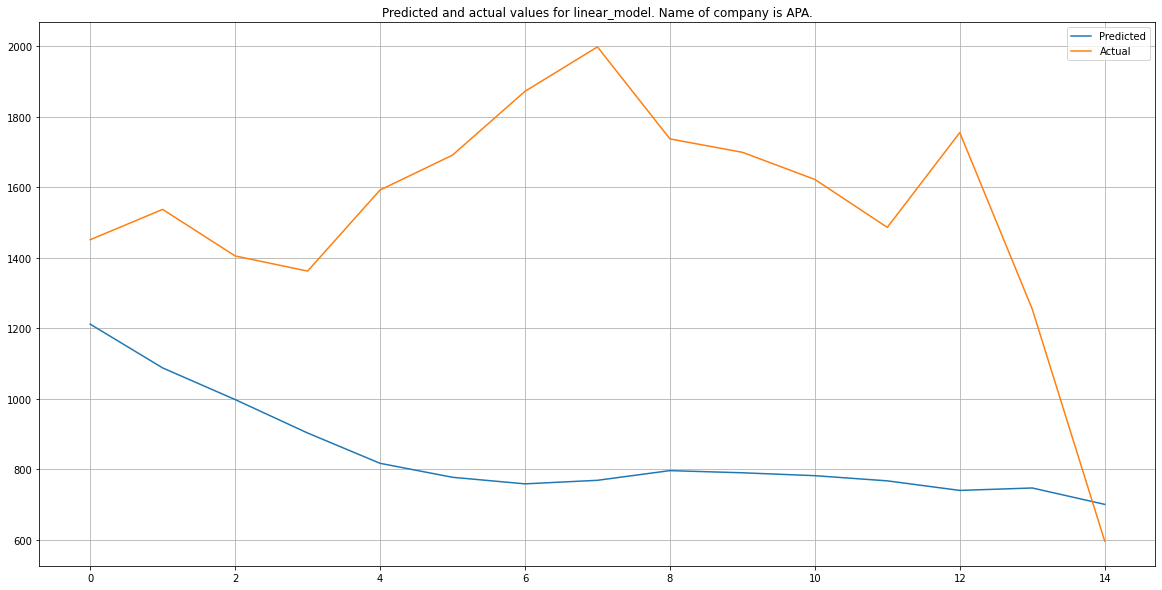

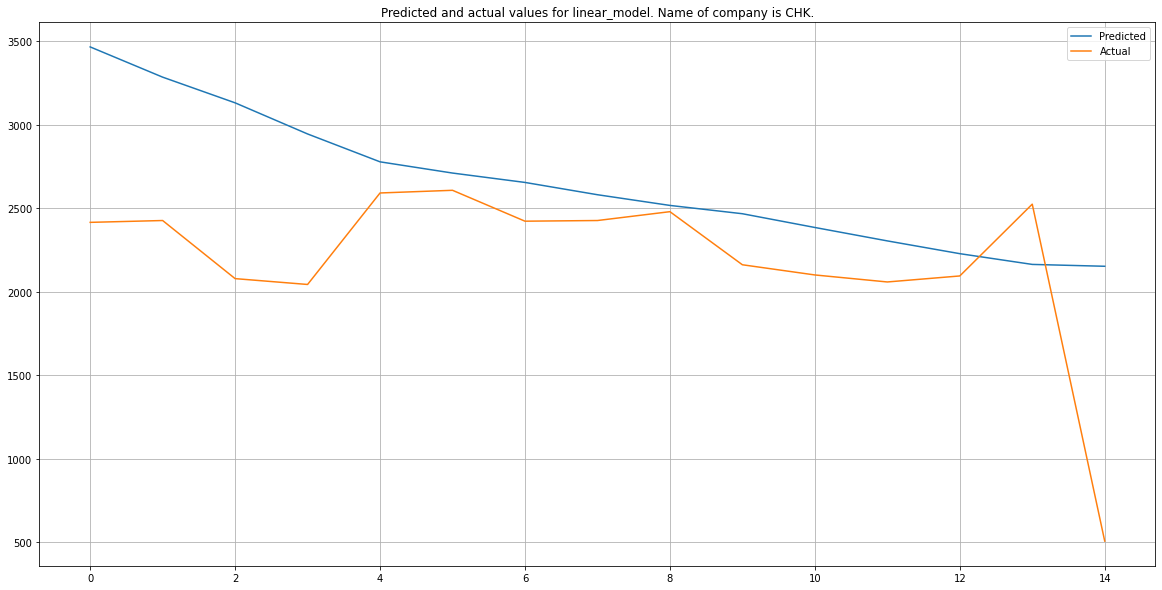

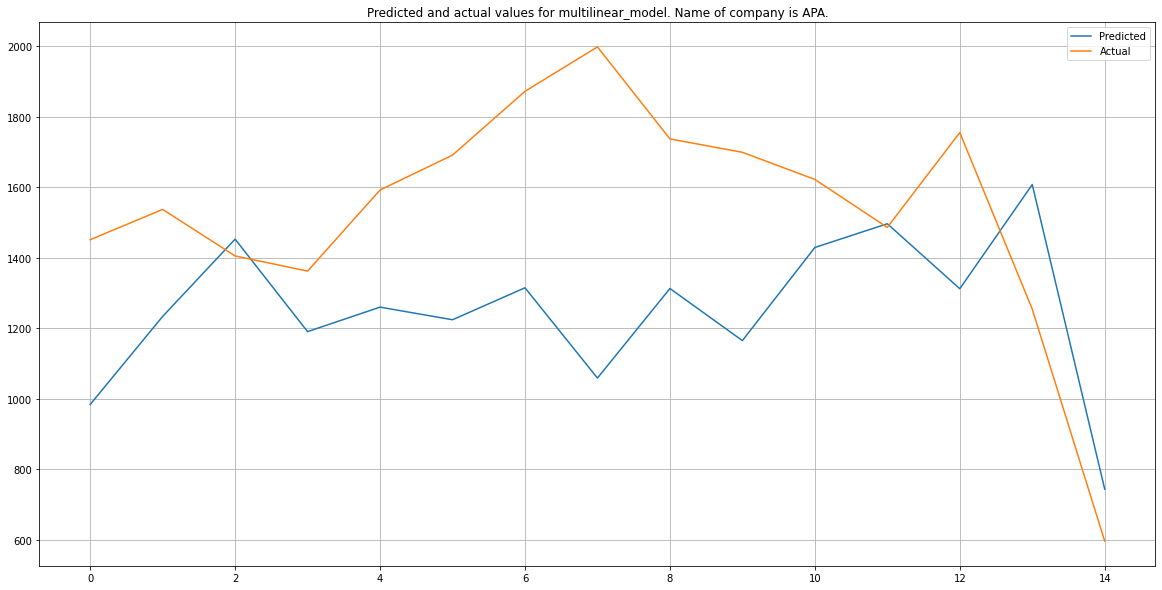

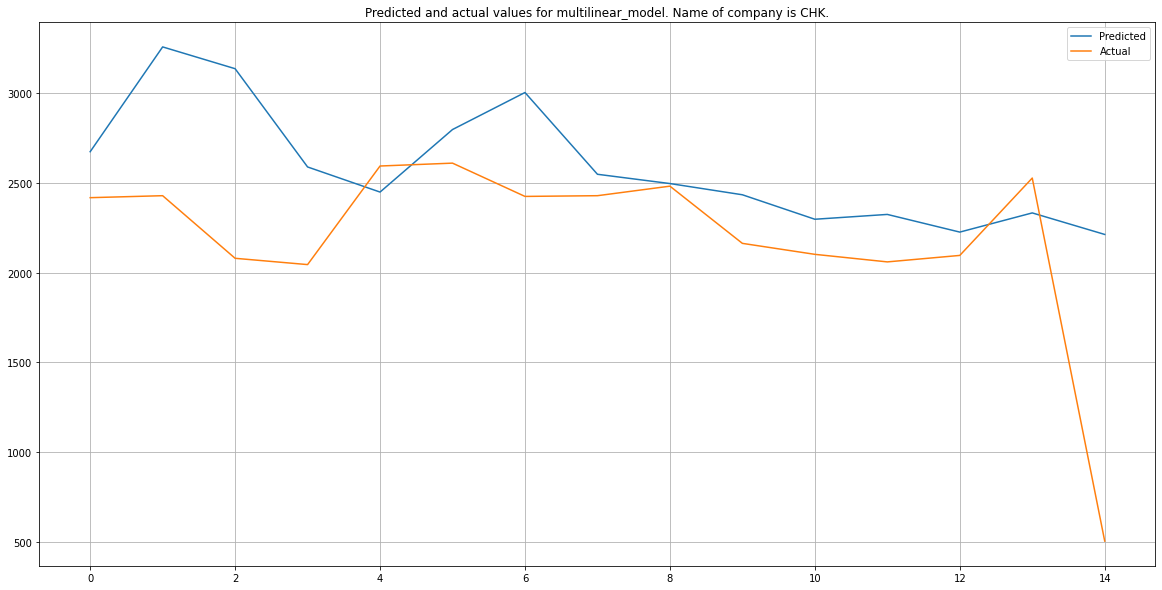

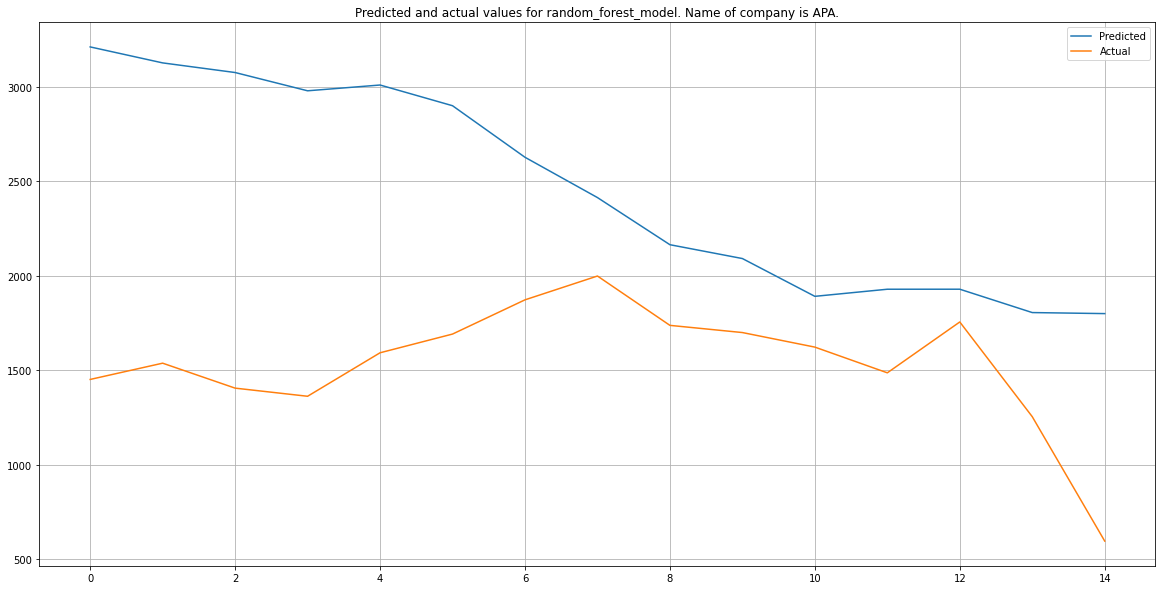

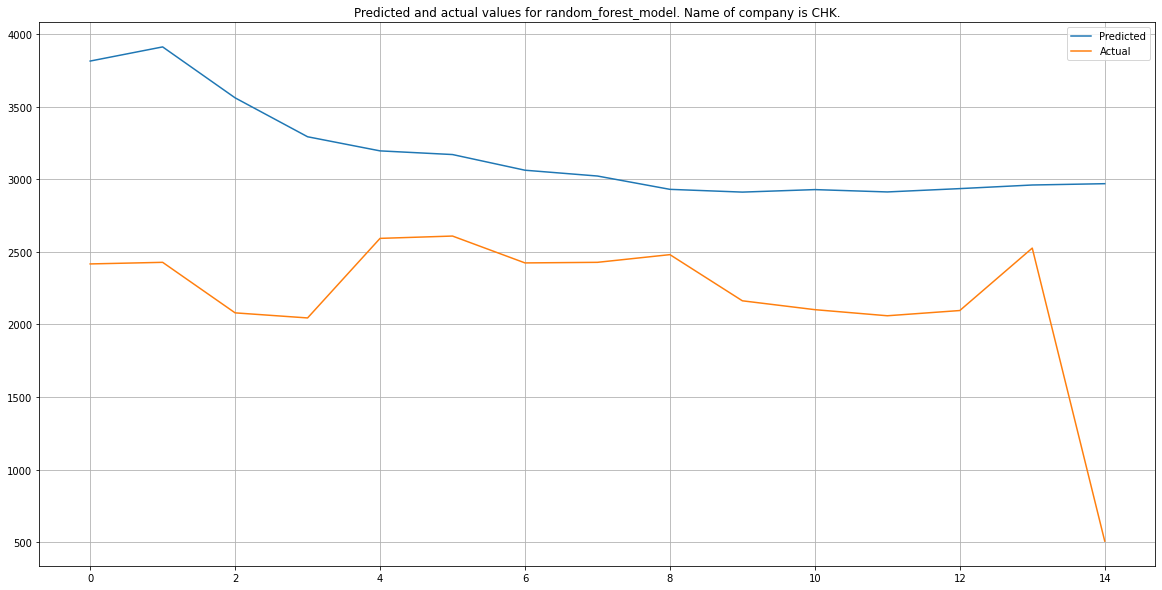

,rev
APA,925.392002
CHK,974.741328


In [158]:
companies_validation(Test_DF_midlle[Test_DF_midlle['company_name'].isin(Some_companies_midlle)] ,'rev', naive_model, mean_absolute_error, plot = True)
companies_validation(Test_DF_midlle[Test_DF_midlle['company_name'].isin(Some_companies_midlle)] ,'rev', linear_model, mean_absolute_error, plot = True)
companies_validation(Test_DF_midlle[Test_DF_midlle['company_name'].isin(Some_companies_midlle)] ,'rev', multilinear_model, mean_absolute_error, plot = True)
companies_validation(Test_DF_midlle[Test_DF_midlle['company_name'].isin(Some_companies_midlle)] ,'rev', random_forest_model, mean_absolute_error, plot = True)

For the future

In [133]:
#feats = {}
#for feature, importance in zip(data.columns, rfc_1.feature_importances_):
#    feats[feature] = importance
#importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
#importances = importances.sort_values(by='Gini-Importance', ascending=False)
#importances = importances.reset_index()
#importances = importances.rename(columns={'index': 'Features'})
#sns.set(font_scale = 5)
#sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
#fig, ax = plt.subplots()
#fig.set_size_inches(30,15)
#sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
#plt.xlabel('Importance', fontsize=25, weight = 'bold')
#plt.ylabel('Features', fontsize=25, weight = 'bold')
#plt.title('Feature Importance', fontsize=25, weight = 'bold')
#display(plt.show())
#display(importances)

In [134]:
#or company_name in Train_DF_small.company_name.unique():
#   DF_of_one_company = Train_DF_small.loc[Train_DF_small.company_name == company_name] 
#   DF_of_one_company['Time'] = np.arange(len(DF_of_one_company.date))
#   new_row = dict(DF_of_one_company.iloc[-1])
#   new_row['rev'] = linear_model(DF_of_one_company, 'rev')
#   new_row['op_in'] = linear_model(DF_of_one_company, 'op_in')
#   new_row['date'] = new_row['date'] + pd.DateOffset(months=3)
#   new_row['Time'] = new_row['Time'] + 1
#   new_row = pd.DataFrame([new_row])
#   print(new_row)
#   Train_DF_small = pd.concat([Train_DF_small, new_row], ignore_index = True)


In [135]:
#Train_DF_Mid_APA = Train_DF.loc[Train_DF.company_name == 'APA']
#Train_DF_Mid_APA['Time'] = np.arange(len(Train_DF_Mid_APA.date))
#Train_DF_Mid_APA = Train_DF_Mid_APA.reset_index(drop=True)
#Train_DF_Mid_APA
#new = dict(Train_DF_Mid_APA.iloc[-1])
#new['rev'] = linear_model(Train_DF_Mid_APA, 'rev')
#new['op_in'] = linear_model(Train_DF_Mid_APA, 'op_in')
#new['date'] = new['date'] + pd.DateOffset(months=3)
#new['Time'] = new['Time'] + 1
#new = pd.DataFrame([new])
#Train_DF_Mid_APA = pd.concat([Train_DF_Mid_APA, new], ignore_index = True)
#model = LinearRegression().fit(np.array(Train_DF_Mid_APA.Time[:]).reshape((-1,1)), Train_DF_Mid_APA.rev[:])
#next = model.coef_[0]*38 + model.intercept_
#next